In [1]:
path = "../input/scene_classification/scene_classification/train/"

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
bs = 64

In [4]:
df = pd.read_csv('../input/scene_classification/scene_classification/train.csv')
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [5]:
tfms = get_transforms(do_flip=False)
data = (ImageItemList.from_csv(path, csv_name='../train.csv') #Where to find the data? -> in path and its subfolders
        .random_split_by_pct()              #How to split in train/valid? -> use the folders
        .label_from_df()            #How to label? -> depending on the folder of the filenames
        .add_test_folder(test_folder = '../test')              #Optionally add a test set (here default name is test)
        .transform(tfms, size=128)       #Data augmentation? -> use tfms with a size of 64
        .databunch())

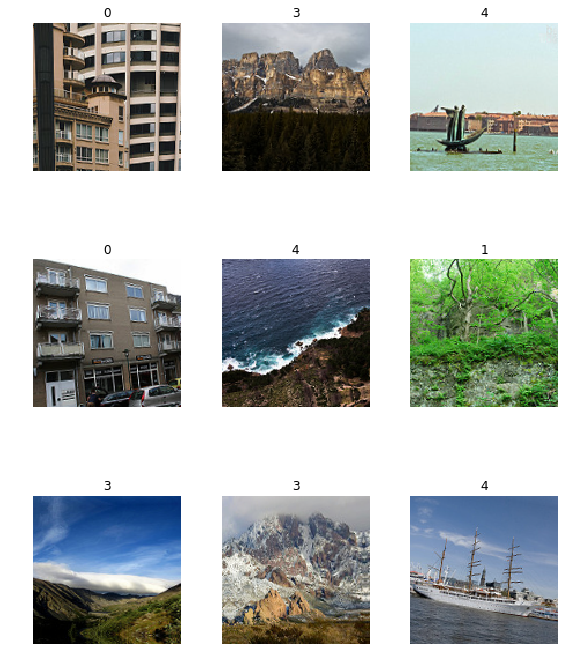

In [6]:
data.show_batch(rows=3, figsize=(8,10))

In [7]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [8]:
learn = create_cnn(data, models.resnet50, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 24975752.01it/s]


In [9]:
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.443227,0.323559,0.113329,0.886671
2,0.355252,0.299943,0.102760,0.897240
3,0.310922,0.260020,0.100117,0.899883
4,0.277050,0.249650,0.083089,0.916911
5,0.247161,0.245913,0.091016,0.908984
6,0.235706,0.232323,0.086612,0.913388
7,0.207166,0.196516,0.069877,0.930123
8,0.187647,0.217900,0.072519,0.927481
9,0.174236,0.212035,0.075749,0.924251
10,0.155082,0.211994,0.069877,0.930123


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [11]:
learn.save('stage-1')

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


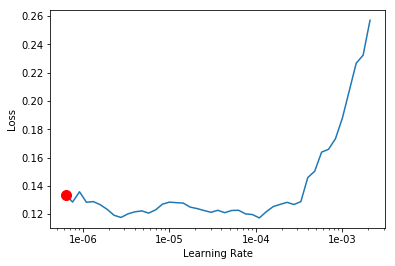

In [14]:
learn.recorder.plot()

In [15]:
 learn.unfreeze()
 learn.fit_one_cycle(4, max_lr=slice(1e-6, 8e-5))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.122813,0.207503,0.070757,0.929242
2,0.107287,0.204556,0.067234,0.932766
3,0.086847,0.206555,0.069583,0.930417
4,0.095235,0.203711,0.069289,0.930710


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


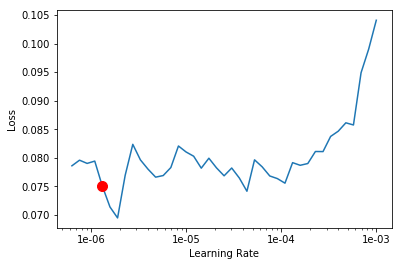

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.save('stage-2')

In [18]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
predsPrime = list(np.array(preds))

In [19]:
labelled_preds = []
for pred in preds:
    labelled_preds.append(int(np.argmax(pred)))
    
# labelled_preds[0:10]
len(labelled_preds)

7301

In [20]:
import os
filenames = os.listdir('../input/scene_classification/scene_classification/test/')

In [21]:
len(filenames) == len(labelled_preds)

True

In [22]:
submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })

submissionPrime = pd.DataFrame(
    {'image_name': filenames,
     'label': predsPrime,
    })

In [23]:
y_test = submission
y_testPrime = submissionPrime

image_name = list(submission['image_name'])
label = list(submission['label'])

image_namePrime = list(submissionPrime['image_name'])
labelPrime = list(submissionPrime['label'])

for i in range(len(submission)):
    if i%1000 == 0:
            print(i)
    for j in range(len(submission)):
        if j+1 < len(submission) and int(image_name[j][:-4]) > int(image_name[j+1][:-4]) :
            temp = image_name[j]
            image_name[j] = image_name[j+1]
            image_name[j+1] = temp
            
            tempPrime =  label[j]
            label[j] = label[j+1]
            label[j+1] = tempPrime
            
            temp = image_namePrime[j]
            image_namePrime[j] = image_namePrime[j+1]
            image_namePrime[j+1] = temp
            
            tempPrime =  labelPrime[j]
            labelPrime[j] = labelPrime[j+1]
            labelPrime[j+1] = tempPrime
            
y_test['image_name'] = pd.DataFrame(image_name)
y_test['label'] = pd.DataFrame(label)
y_test.to_csv('S1.csv')

y_testPrime['image_name'] = image_namePrime
y_testPrime['label'] = labelPrime
y_testPrime.to_csv('R1.csv')

0
1000
2000
3000
4000
5000
6000
7000


In [24]:
y_testPrime.head()

,image_name,label
0,3.jpg,"[1.2294013e-06, 9.532266e-09, 2.7730834e-10, 1..."
1,5.jpg,"[0.99999046, 3.5230418e-08, 1.6606032e-08, 2.6..."
2,6.jpg,"[2.0511132e-08, 1.1467544e-07, 1.8600014e-07, ..."
3,11.jpg,"[6.851001e-05, 0.0013127166, 0.6906921, 0.0327..."
4,14.jpg,"[0.0017576932, 3.794856e-08, 2.2018476e-06, 4...."
